In [1]:
# Import libraries and set desired options
import warnings
warnings.filterwarnings('ignore')

from typing import Tuple, List

import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

from tqdm import tqdm_notebook as tqdm

# 1.Data preparation

In [2]:
%%time
# Read the training and test data sets, change paths if needed
times = ['time%s' % i for i in range(1, 11)]
sites = ['site%s' % i for i in range(1, 11)]

train_df = pd.read_csv('./train_sessions.csv',
                       index_col='session_id', parse_dates=times)
test_df = pd.read_csv('./test_sessions.csv',
                      index_col='session_id', parse_dates=times)

# Sort the data by time
train_df = train_df.sort_values(by='time1')

# Change site1, ..., site10 columns type to integer and fill NA-values with zeros
train_df[sites] = train_df[sites].fillna(0).astype(np.uint16)
test_df[sites] = test_df[sites].fillna(0).astype(np.uint16)

# Load websites dictionary
with open(r"./site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)

# Create dataframe for the dictionary
sites_dict = pd.DataFrame(list(site_dict.keys()), index=list(site_dict.values()), 
                          columns=['site'])

train_df[sites].fillna(0).astype('int').to_csv('train_sessions_text.txt', 
                                               sep=' ', 
                       index=None, header=None)
test_df[sites].fillna(0).astype('int').to_csv('test_sessions_text.txt', 
                                              sep=' ', 
                       index=None, header=None)

# Create a separate dataframe where we will work with timestamps
time_df = pd.DataFrame(index=train_df.index)

time_df['target'] = train_df['target']
time_df['min'] = train_df[times].min(axis=1)
time_df['max'] = train_df[times].max(axis=1)
time_df['seconds'] = (
    (time_df['max'] - time_df['min']) / np.timedelta64(1, 's'))

# Index to split the training and test data sets
idx_split = train_df.shape[0]

# Our target variable
y_train = train_df['target']

# United dataframe of the initial data 
full_df = pd.concat([train_df.drop('target', axis=1), test_df])

cv = CountVectorizer(ngram_range=(1, 3), max_features=50000)
with open('train_sessions_text.txt') as inp_train_file:
    X_train_cv = cv.fit_transform(inp_train_file)
with open('test_sessions_text.txt') as inp_test_file:
    X_test_cv = cv.transform(inp_test_file)
    
time_split = TimeSeriesSplit(n_splits=10)

# Dataframe with indices of visited websites in session
full_sites = full_df[sites]

# sequence of indices
sites_flatten = full_sites.values.flatten()

# and the matrix we are looking for 
# (make sure you understand which of the `csr_matrix` constructors is used here)
# a further toy example will help you with it
full_sites_sparse = csr_matrix(
    ([1] * sites_flatten.shape[0],
    sites_flatten,
    range(0, sites_flatten.shape[0]  + 10, 10))
)[:, 1:]

X_train = full_sites_sparse[:idx_split, :]
X_test = full_sites_sparse[idx_split:,:]

CPU times: user 23.7 s, sys: 683 ms, total: 24.4 s
Wall time: 24.4 s


### TimeSeries cross-validation demo

In [3]:
[(el[0].shape, el[1].shape) for el in time_split.split(X_train_cv)]

[((23051,), (23051,)),
 ((46102,), (23051,)),
 ((69153,), (23051,)),
 ((92204,), (23051,)),
 ((115255,), (23051,)),
 ((138306,), (23051,)),
 ((161357,), (23051,)),
 ((184408,), (23051,)),
 ((207459,), (23051,)),
 ((230510,), (23051,))]

In [4]:
%%time

# logit = LogisticRegression(C=1, random_state=17, solver='liblinear')

# cv_scores = cross_val_score(
#     logit, X_train_cv, y_train, 
#     cv=time_split, scoring='roc_auc', n_jobs=1) 
# hangs with n_jobs > 1, and locally this runs much faster

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.78 µs


In [5]:
# cv_scores, cv_scores.mean()

### Continue preparations

In [6]:
def get_auc_lr_valid(X, y, C=1.0, seed=17, ratio = 0.9):
    # Split the data into the training and validation sets
    idx = int(round(X.shape[0] * ratio))
    # Classifier training
    lr = LogisticRegression(C=C, random_state=seed, solver='liblinear').fit(X[:idx, :], y[:idx])
    # Prediction for validation set
    y_pred = lr.predict_proba(X[idx:, :])[:, 1]
    # Calculate the quality
    score = roc_auc_score(y[idx:], y_pred)
    
    return score

In [7]:
# Function for writing predictions to a file
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

# 2.Feature Engineering

In [8]:
SESSION_ID = 'session_id'
TARGET = 'target'

In [9]:
YEAR = 'year'
DAY_OF_THE_WEEK = 'day_of_the_week'
WEEK = 'week'
HOUR = 'hour'
FINISH_HOUR = 'finish_hour'
MORNING = 'morning' # 7 - 11
DAY = 'day' # 12 - 18
EVENING = 'evening' # 17 - 23 
NIGHT = 'night' # 0 - 6
START_MONTH = 'start_month'
MONTH = 'month'
UNIQUE_SITES_IN_SESSION = 'unique_sites_in_session'
SLEEPING_TIME = 'sleeping_time'
SESSION_LENGTH = 'session_length'

ALICE_HOUR = 'alice_hour'
ALICE_HOUR_100 = 'alice_hour_100' # more than 100
ALICE_HOUR_200 = 'alice_hour_200' # more than 100
WORKING_WEEKDAY = 'working_weekday' # increment by 1 because of 0 - Monday?
ALICE_WEEKDAY = 'alice_weekday'
ALICE_WEEKDAY_200 = 'alice_weekday_200'

In [10]:
full_df.shape, time_df.shape

((336358, 20), (253561, 4))

## Simple features

CPU times: user 1min 16s, sys: 2.68 s, total: 1min 19s
Wall time: 1min 16s


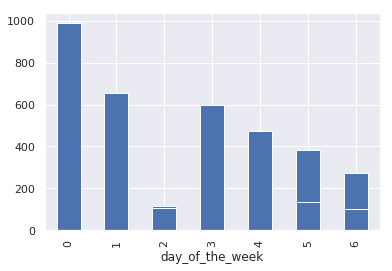

In [11]:
%%time
# Dataframe for new features
full_new_feat = pd.DataFrame(index=full_df.index)

full_new_feat[START_MONTH] = full_df['time1'].apply(
    lambda ts: 
        (ts.year) * 100 + ts.month
).astype('float64')

full_new_feat[YEAR] = full_df['time1'].apply(
    lambda ts: ts.year
).astype('int16')

full_new_feat[DAY_OF_THE_WEEK] = full_df['time1'].apply(
    lambda ts: ts.dayofweek
).astype('int8')

full_new_feat[WEEK] = full_df['time1'].apply(
    lambda ts: ts.week
).astype('int8')

full_new_feat[HOUR] = full_df['time1'].apply(
    lambda ts: ts.hour
).astype('int8')

exam_df = (
    full_new_feat[HOUR]
    .to_frame()
    .join(time_df[TARGET].to_frame(), on='session_id')
)

grouped_by_hour = exam_df[exam_df[TARGET] == 1].groupby(HOUR).size()
grouped_by_hour_100 = grouped_by_hour[grouped_by_hour > 100]
grouped_by_hour_200 = grouped_by_hour_100[grouped_by_hour_100 > 200]

ALICE_HOURS_LIST = grouped_by_hour.index

grouped_by_hour.plot(kind='bar')

full_new_feat[MORNING] = full_df['time1'].apply(
    lambda ts: ts.hour >= 0 and ts.hour <= 11
).astype('int8')

full_new_feat[DAY] = full_df['time1'].apply(
    lambda ts: ts.hour >= 12 and ts.hour <= 18
).astype('int8')

full_new_feat[EVENING] = full_df['time1'].apply(
    lambda ts: ts.hour >= 19 and ts.hour <= 23
).astype('int8')

full_new_feat[NIGHT] = full_df['time1'].apply(
    lambda ts: ts.hour >= 0 and ts.hour <= 6
).astype('int8')

full_new_feat[MONTH] = full_df['time1'].apply(
    lambda ts: ts.month
).astype('int8')

full_new_feat[UNIQUE_SITES_IN_SESSION] = (
    train_df[sites].replace({0:  None}).nunique(axis=1, dropna=True))

full_new_feat[SLEEPING_TIME] =  full_df['time1'].apply(
    lambda ts: 
        ts.hour >=0 and ts.hour <= 7
).astype('int8')

full_new_feat[SESSION_LENGTH] = (full_df[times].max(axis=1) - full_df[times].min(axis=1)) / np.timedelta64(1, 's')

full_new_feat[ALICE_HOUR] = full_new_feat[HOUR].apply(
    lambda ts:
        ts in grouped_by_hour
).astype('int8')

full_new_feat[ALICE_HOUR_100] = full_new_feat[HOUR].apply(
    lambda ts:
        ts in grouped_by_hour_100
).astype('int8')

full_new_feat[ALICE_HOUR_200] = full_new_feat[HOUR].apply(
    lambda ts:
        ts in grouped_by_hour_200
).astype('int8')

exam_df = (
    full_new_feat[DAY_OF_THE_WEEK]
    .to_frame()
    .join(time_df[TARGET].to_frame(), on='session_id')
)

grouped_by_weekday = exam_df[
    exam_df[TARGET] == 1].groupby(DAY_OF_THE_WEEK).size()
working_days = [range(0, 6)]
alice_weekday_200 = grouped_by_weekday[grouped_by_weekday > 200]

ALICE_WEEKDAYS_LIST = grouped_by_weekday.index

grouped_by_weekday.plot(kind='bar')

full_new_feat[ALICE_WEEKDAY] = full_new_feat[DAY_OF_THE_WEEK].apply(
    lambda ts:
        ts in grouped_by_weekday
).astype('int8')

full_new_feat[ALICE_WEEKDAY_200] = full_new_feat[DAY_OF_THE_WEEK].apply(
    lambda ts:
        ts in alice_weekday_200
).astype('int8')

full_new_feat[WORKING_WEEKDAY] = full_new_feat[DAY_OF_THE_WEEK].apply(
    lambda ts:
        ts in working_days
).astype('int8')

In [12]:
full_new_feat.head().T

session_id,21669,54843,77292,114021,146670
start_month,201301.0,201301.0,201301.0,201301.0,201301.0
year,2013.0,2013.0,2013.0,2013.0,2013.0
day_of_the_week,5.0,5.0,5.0,5.0,5.0
week,2.0,2.0,2.0,2.0,2.0
hour,8.0,8.0,8.0,8.0,8.0
morning,1.0,1.0,1.0,1.0,1.0
day,0.0,0.0,0.0,0.0,0.0
evening,0.0,0.0,0.0,0.0,0.0
night,0.0,0.0,0.0,0.0,0.0
month,1.0,1.0,1.0,1.0,1.0


In [13]:
full_new_feat.shape, y_train.shape

((336358, 19), (253561,))

In [14]:
full_new_feat[TARGET] = y_train

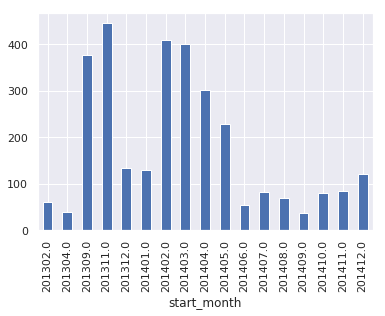

In [15]:
full_new_feat[
    full_new_feat[TARGET] == 1
].groupby(START_MONTH).size().plot(kind='bar')

In [16]:
def audit_features(
    features_set: pd.DataFrame=full_new_feat, 
    print_all=False, 
    sort_results=False,
    additional_features=None
):
    features = list(full_new_feat.columns)
    results = []
    
    for feature_set in tqdm(list(features_set.columns)):
        tmp = StandardScaler().fit_transform(features_set[[feature_set]])
        
        if additional_features:
            hstacked = [full_sites_sparse[:idx_split,:], tmp[:idx_split,:], additional_features]
        else:
            hstacked = [full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]
            
        X_train = csr_matrix(hstack(hstacked))

        # Compute metric on the validation set
        score = get_auc_lr_valid(X_train, y_train)

        results.append((score, feature_set))
        
        if print_all:
            print(f'Score: {score}, Features: {feature_set}')
            
    if sort_results:
        results.sort(key=lambda result: result[0], reverse=True)

    return results

In [17]:
def calculate_cross_validation(features_set, addintional_features=None) -> Tuple[List[float], float]:
    logit = LogisticRegression(C=1, random_state=17, solver='liblinear')
    tmp = StandardScaler().fit_transform(features_set)
    
    if addintional_features is not None:
        hstacked = [
            full_sites_sparse[:idx_split,:], 
            tmp[:idx_split,:], 
            addintional_features
        ]
    else:
        hstacked = [
            full_sites_sparse[:idx_split,:], 
            tmp[:idx_split,:], 
        ]
    
    X_train = csr_matrix(
        hstack(hstacked)
    )
    
    cv_scores = cross_val_score(
        logit, X_train, y_train, cv=time_split, 
        scoring='roc_auc', n_jobs=1) 
    # hangs with n_jobs > 1, and locally this runs much faster
    
    return cv_scores, cv_scores.mean()

In [18]:
results = audit_features(full_new_feat, sort_results=True)

FEATURE_SET = [result[1] for result in results if result[1] != 'target']

results

/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int16 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int16 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int8 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int8 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int8 were all converted to float64 by StandardScaler.
 

[(1.0, 'target'),
 (0.9565884665642557, 'hour'),
 (0.9534949265490873, 'alice_hour_200'),
 (0.949085924404253, 'day'),
 (0.947403479438092, 'morning'),
 (0.9367918484220493, 'alice_hour_100'),
 (0.9365577100512539, 'day_of_the_week'),
 (0.9339618084237884, 'alice_weekday_200'),
 (0.9213209781941848, 'evening'),
 (0.9197239008931979, 'session_length'),
 (0.9196984641972088, 'start_month'),
 (0.9196222295890517, 'year'),
 (0.9195973967315431, 'sleeping_time'),
 (0.9195912828669284, 'alice_hour'),
 (0.9195228981590172, 'night'),
 (0.9195228981590172, 'alice_weekday'),
 (0.9195228981590172, 'working_weekday'),
 (0.9189685744339617, 'month'),
 (0.9184734268799908, 'week'),
 (0.9161822372457236, 'unique_sites_in_session')]

In [19]:
%%time
cv_scores_1, cv_scores_mean_1 = calculate_cross_validation(full_new_feat[FEATURE_SET], X_train_cv)
cv_scores_2, cv_scores_mean_2 = calculate_cross_validation(full_new_feat[FEATURE_SET])
cv_scores_3, cv_scores_mean_3 = calculate_cross_validation(
    full_new_feat[list(set(FEATURE_SET) - {HOUR})], 
    X_train_cv
)
cv_scores_4, cv_scores_mean_4 = calculate_cross_validation(
    full_new_feat[list(set(FEATURE_SET) - {HOUR, YEAR})], 
    X_train_cv
)

/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int8, int16, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int8, int16, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int8, int16, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int8, int16, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConver

CPU times: user 20min 38s, sys: 29min 33s, total: 50min 11s
Wall time: 8min 36s


In [20]:
cv_scores_2 > cv_scores_1, cv_scores_mean_1 > cv_scores_mean_2

(array([ True,  True, False, False, False, False, False, False, False,
         True]), True)

In [21]:
cv_scores_3 > cv_scores_1, cv_scores_mean_3 > cv_scores_mean_1, cv_scores_mean_3

(array([ True,  True, False, False,  True, False,  True,  True, False,
        False]), True, 0.9390573489523554)

In [22]:
cv_scores_4 > cv_scores_3, cv_scores_mean_4 > cv_scores_mean_3, cv_scores_mean_4

(array([False, False,  True, False,  True, False,  True, False, False,
        False]), False, 0.9388148605972424)

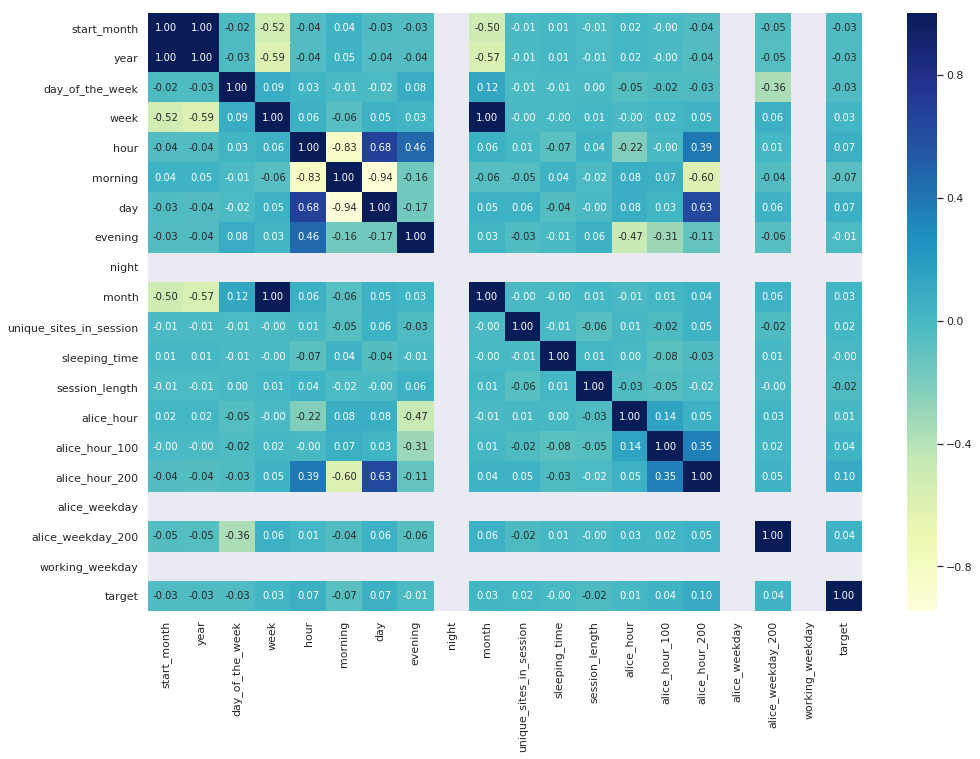

In [23]:
corr = full_new_feat.corr('pearson') 
plt.figure(figsize = ( 16 , 11 )) 
sns.heatmap(corr,annot=True,fmt='.2f',cmap="YlGnBu");

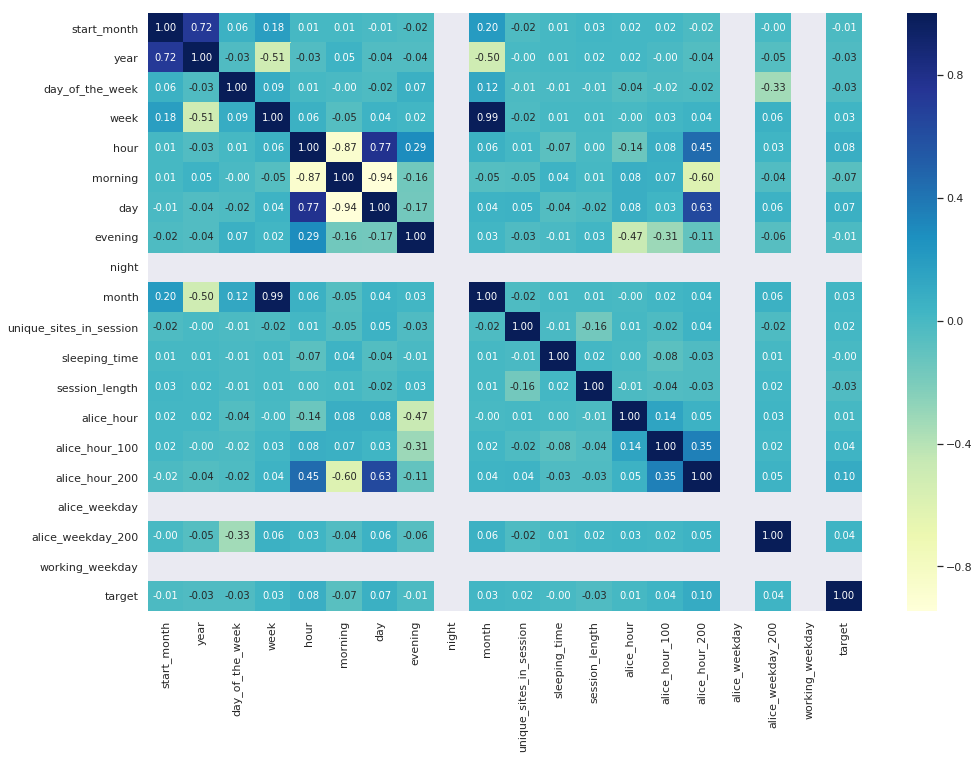

In [24]:
corr = full_new_feat.corr('spearman') 
plt.figure(figsize = ( 16 , 11 )) 
sns.heatmap(corr,annot=True,fmt='.2f',cmap="YlGnBu");

In [25]:
X_train_cv.shape, full_sites_sparse[:idx_split,:].shape

((253561, 50000), (253561, 48371))

### `C` Param Regularization

In [26]:
# c_values = np.logspace(-2, 2, 10)

# logit_grid_searcher = GridSearchCV(
#     estimator=logit, 
#     param_grid={'C': c_values},
#     scoring='roc_auc', n_jobs=1, cv=time_split, verbose=1)

In [27]:
# %%time
# logit_grid_searcher.fit(X_train, y_train)

In [28]:
# logit_grid_searcher.best_score_, logit_grid_searcher.best_params_

In [29]:
# logit_test_pred3 = logit_grid_searcher.predict_proba(X_test)[:, 1]
# write_to_submission_file(logit_test_pred3, '5_attempt.csv')

### Old-fashioned C param regulization (faster approach)

In [30]:
tmp_scaled = StandardScaler().fit_transform(full_new_feat[list(set(FEATURE_SET) - {HOUR})])

/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int8, int16, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int8, int16, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [31]:
X_test = csr_matrix(hstack([full_sites_sparse[idx_split:,:], 
                            tmp_scaled[idx_split:,:],
                            X_test_cv
                           ]))

X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], 
                            tmp_scaled[:idx_split,:],
                            X_train_cv
                           ]))

In [32]:
%%time

score_C_1 = get_auc_lr_valid(X_train, y_train)

# Compute metric on the validation set
Cs = np.logspace(-2, 0, 15)
scores = []
for C in tqdm(Cs):
    scores.append(get_auc_lr_valid(X_train, y_train, C=C))


CPU times: user 10min 27s, sys: 15min 6s, total: 25min 34s
Wall time: 4min 25s


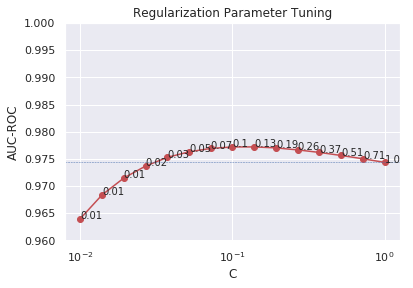

In [33]:
plt.plot(Cs, scores, 'ro-')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('AUC-ROC')
plt.title('Regularization Parameter Tuning')
# horizontal line -- model quality with default C value
plt.axhline(y=score_C_1, linewidth=.5, color='b', linestyle='dashed') 

MINIMAL_THRESHOLD = 0.96

axes = plt.gca()
axes.set_ylim([MINIMAL_THRESHOLD, 1])

list_of_results = [
    (C, score) 
    for C, score in list(zip(Cs, scores)) 
    if score >= MINIMAL_THRESHOLD
]

for C, score in list_of_results: 
    plt.text(C, score, str(C)[:4])

plt.show()

In [34]:
list_of_results.sort(
    key=lambda score_pair: score_pair[1], 
    reverse=True)

max_C = list_of_results[0][0]

max_C

0.13894954943731375

In [35]:
# Prepare the training and test data
C=max_C

X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], 
                             tmp_scaled[:idx_split,:],
                             X_train_cv
                            ]))

In [36]:
# Train the model on the whole training data set using optimal regularization parameter
lr = LogisticRegression(C=C, random_state=17, solver='liblinear').fit(X_train, y_train)

# Make a prediction for the test set
y_test = lr.predict_proba(X_test)[:, 1]


# Write it to the submission file
write_to_submission_file(y_test, 'attempt_6.csv')